In [40]:
import py21cmfast as p21c
from matplotlib import pyplot as plt
import os 
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)
from py21cmfast import plotting
from py21cmfast import cache_tools
from multiprocessing import Pool
import timeit
import numpy as np
import random
import yaml
import itertools
from powerbox.tools import get_power

cache_path = "../_cache"

if not os.path.exists(cache_path):
    os.mkdir(cache_path)

p21c.config['direc'] = cache_path
# cache_tools.clear_cache(direc=cache_path)

print(f"Using 21cmFAST version {p21c.__version__}")

class Parameters():    
    '''Auxillary class to initialize and update parameters given a config file or on the fly.'''
    def __init__(self, random_seed=True, parameter_path="./"):
        self.prechange = True
        self.random_seed = random_seed
        with open(parameter_path + "parameter.yaml", 'r') as file:
            parameter = yaml.safe_load(file)
        
        
        use_default = []
        for key in parameter.keys():
            if key == "input_params":
                self.input_params = parameter["input_params"]
            else:
                print(f"use {key} default config: {parameter[key]["use_default"]}")
                use_default.append(parameter[key]["use_default"])
                parameter[key].pop("use_default")
        parameter.pop("input_params")
        
        self.astro_params = parameter["astro_params"] if not use_default[0] else p21c.AstroParams()
        self.cosmo_params = parameter["cosmo_params"] if not use_default[1] else p21c.CosmoParams()
        self.user_params = parameter["user_params"] if not use_default[2] else p21c.UserParams()
        self.flag_params = parameter["flag_options"] if not use_default[3] else p21c.FlagOptions()
        self.global_params = parameter["global_params"] if not use_default[4] else {}
        parameter.pop("global_params")
        
        self.input_params.update(parameter)
        self.standard_config = self.input_params.copy() 
        
    def kwargs_update(self, kargs):
        self.input_params.update(kargs)
        
            
    def pbox_run(self, zsteps):
        if self.prechange:
            self.prechange = False
            self.lcone_quantities = self.input_params.pop("lightcone_quantities")
            self.z = [self.input_params["redshift"] + (self.input_params["max_redshift"] - self.input_params["redshift"])/zsteps * i for i in range(zsteps+1)] 
            self.input_params["redshift"] = self.z
            self.input_params.pop("max_redshift")
        else:
            self.prechange = False
            self.input_params["lightcone_quantities"] = self.lcone_quantities
            self.input_params["redshift"] = self.z[0]
            self.input_params["max_redshift"] = self.z[-1]
            
    def randomize(self):
        self.input_params["random_seed"] = random.randint(0,99999)
                
            
        
    
class Simulation(Parameters):
    '''Dynamically execute and plot simulations.'''
    def __init__(self, random_seed=True):
        super().__init__(random_seed=random_seed)
        self.data = []
        self.randseed = random_seed
        
    def __len__(self):
        '''Returns length of the data-array'''
        return len(self.data)
        
    def run_box(self, runs, zsteps, kargs={}):
        '''Run a simple box simulation'''
        self.simtype = 0
        self.pbox_run(zsteps)
        with p21c.global_params.use(**self.global_params):
            for _ in range(runs):
                self.kwargs_update(kargs)
                self.data.append(p21c.run_coeval(**self.input_params))
        self.pbox_run(zsteps)
    
    def run_lightcone(self, runs, kargs={}):
        '''Run a simple lightcone simulation'''
        self.simtype = 1
        with p21c.global_params.use(**self.global_params):
            for _ in range(runs):
                if self.randseed: self.randomize()
                self.kwargs_update(kargs)
                self.data.append(p21c.run_lightcone(**self.input_params))
                
    def run_fixed_multi_lightcone(self, rargs):
        '''Compute multiple lightcones given a list of parameters as a dict with list entries
        e.g. rargs = {"NU_X_THRESH": [1,2,3], "HII_EFF_FACTOR": [1,2], ...}'''
        for values in itertools.product(*rargs.values()):
            run_params = (lambda d, values: {k: v for k, v in zip(d.keys(), values)})(rargs, values)
            print("Parameter run: ",run_params)
            self.run_lightcone(runs=1, kargs=run_params)
            
    def plot_global_properties(self, run=[-1], observational_axis = False, print_params = ['']):
        '''Make a plot of the global quantities of the lightcone
        run: array of run_ids which should be printed
        observational_axis: plot the x-axis in MHz instead of redshift
        print_params: Additional array of parameters which are printed as plain text for debug reasons'''
        x_map = (lambda z: 1420.4/(z + 1)) if observational_axis else (lambda z: z)
        if run[0] == -1:
            run = range(len(self.data))
        if self.simtype != 1:
            print("Non-lightcone simulation not supported.")
            return
        w,h = len(run), len(self.data[0].global_quantities)
        fig, ax = plt.subplots(h,w, figsize=(4*w,4*h))
        ax = ax.reshape(h,w)
        for r in run:
            add_string = ''
            for p in print_params:
                if p != '': add_string += p + '=' + str(self.data[r].astro_params.defining_dict[p]) + ', '
            title = f"run={r}"
            if add_string != '': title += '\n' + add_string
            ax[0,r].set_title(f"{title}")
            for q, quantity in enumerate(self.data[r].global_quantities.keys()):
                ax[q,r].plot(x_map(np.array(self.data[r].node_redshifts)), self.data[r].global_quantities[quantity])
                ax[q,r].set_xlabel("MHz" if observational_axis else "z")
                ax[q,r].set_ylabel(quantity)
        plt.tight_layout()
        plt.show()
            
    def plot_imshow(self, run=-1, fields=["brightness_temp"], print_params = [''], extended=True):
        '''
        run: plot given run, -1 to print them all
        fiels: list of fields that should be printed
        print_params: also show given parameters on the plots (only astro parameter!)
        extended: make additional graphs and statistics'''
        if run == -1:
            data = self.data
        else: 
            data = [self.data[run]]
        match self.simtype:
            case 0:
                h = len(data)
                w = len(data[0])
                for field in fields:
                    fig, ax = plt.subplots(h,w, figsize=(4*w,4*h))
                    ax = ax.reshape(h,w)
                    for (j, axis) in zip(range(len(data)),  ax):
                        add_string = ''
                        for p in print_params:
                            if p != '': add_string += p + '=' + str(data[j].astro_params.defining_dict[p]) + ', '
                        for i, (dat, redshift, a) in enumerate(zip(data[j], [z.redshift for z in self.data[j]], axis)):
                            if i<1:
                                plotting.coeval_sliceplot(dat, ax=a, fig=fig, kind=field)
                            else:
                                plotting.coeval_sliceplot(dat, ax=a, fig=fig, kind=field, printlabel=False)
                            title = f"{field}, z = {round(redshift,2)}"
                            if add_string != '': title += '\n' + add_string
                            plt.title(title)
                    plt.tight_layout()
                    plt.show()
            case 1:
                h = len(data)
                for field in fields:
                    fig, ax = plt.subplots(h,1, figsize=(12,4*h))
                    ax = ax.flatten() if h > 1 else [ax]
                    for i, dat in enumerate(data):
                        add_string = ''
                        for p in print_params:
                            if p != '': add_string += p + " = " + str(data[i].astro_params.defining_dict[p]) + ', '
                        z = dat.node_redshifts
                        plotting.lightcone_sliceplot(dat, ax=ax[i], fig=fig, kind=field)
                        title = f"{field}, z = [{round(max(z),2)} -> {round(min(z),2)}] in {len(z)} steps, run = {i+1} "
                        if add_string != '': title += '\n' + add_string
                        plt.title(title)
                    ax = np.reshape(ax, (h,1))
                    plt.tight_layout()
                    plt.show()     
                    
    def plot_ps(self, bins=10, run=[-1], compare=False, observational_axis = False, logp = True):
        '''Plot the power spectra given a fixed bin number. (Future: Do the same with a dz range but p21cm saves lightcone with constant physical distances not redshift ->)
        run (array): plot ps of given run, -1 to print them all
        compare (bool): Activating compare puts all simulations with equal redshift range in a single plot (useful to compare the ps of different simualtions)
        in_f (bool): changes the x axis from k in Mpc^-3 to lambda in real space (Mpc^3)
        logp (bool): Activating make the plots in log-log axis.
        '''
        binspace = np.linspace(0,len(self.data[0].lightcone_redshifts)-1,bins).astype(int)
        
        x_map = (lambda k: 2*np.pi/k) if observational_axis else (lambda k: k)
        
        if run[0] == -1:
            run = range(len(self.data))
            
            
        if not compare: 
            h,w = len(run),bins-1
            fig, ax = plt.subplots(h,w, figsize=(4*w,4*h))
            ax = ax.reshape(h,w)
            for r in run:
                for bin in range(w):
                    physical_size = self.data[r].lightcone_distances[binspace[bin+1]] - self.data[r].lightcone_distances[binspace[bin]]
                    #print(f"binspace: {binspace[bin]}, brightness map: {self.data[r].brightness_temp[:,:,binspace[bin]:binspace[bin+1]].shape}, boxlength= {(*self.data[r].brightness_temp.shape[:2], physical_size)}")
                    ps = get_power(deltax= self.data[r].brightness_temp[:,:,binspace[bin]:binspace[bin+1]], boxlength=(*self.data[r].brightness_temp.shape[:2], physical_size), bin_ave=True, ignore_zero_mode=True, get_variance=False, bins=50)
                    ax[r,bin].plot(x_map(ps[1]), ps[0]*ps[1]**3)
                    ax[-1,bin].set_xlabel('m in Mpc^3' if observational_axis else "k in Mpc^-3")
                    #ax[r,bin].set_ylabel("P")
                    ax[0,bin].set_title(f'{round(self.data[r].lightcone_redshifts[binspace[bin]],1)} < z < {round(self.data[r].lightcone_redshifts[binspace[bin+1]],1)}')
                    ax[r,0].set_ylabel(f"P(k) * k ^ 3 ; run: {r}")
                    if logp:
                        ax[r,bin].set_xscale("log")
                        ax[r,bin].set_yscale("log")
        else:
            h,w = len(run), bins-1
            fig, ax = plt.subplots(w,1, figsize=(4*h,4*w))
            for r in run:
                for bin in range(w):
                    physical_size = self.data[r].lightcone_distances[binspace[bin+1]] - self.data[r].lightcone_distances[binspace[bin]]
                    ps = get_power(deltax= self.data[r].brightness_temp[:,:,binspace[bin]:binspace[bin+1]], boxlength=(*self.data[r].brightness_temp.shape[:2], physical_size), bin_ave=True, ignore_zero_mode=True, get_variance=False,bins=50)
                    ax[bin].plot(x_map(ps[1]), ps[0]*ps[1]**3, label=f"run {r}")
                    ax[bin].set_title(f'{round(self.data[r].lightcone_redshifts[binspace[bin]],1)} < z < {round(self.data[r].lightcone_redshifts[binspace[bin+1]],1)}')
                    ax[bin].set_xlabel('m in Mpc^3' if observational_axis else "k in Mpc^-3")
                    ax[bin].set_ylabel(f"P(k) * k ^ 3 ; run: {r}")
                    ax[bin].legend()
                    if logp:
                        ax[bin].set_xscale("log")
                        ax[bin].set_yscale("log")
        
        plt.tight_layout()
        plt.savefig("./ps_test.jpg")
        plt.show()

    def pop(self,idx):
        '''Delete a run with idx'''
        self.data.pop(idx)
        
    def clear(self):
        '''Clear the data/runs cache'''
        self.data.clear()

Using 21cmFAST version 3.3.1


In [44]:
params = {"redshift": [6], "max_redshift": [18], "random_seed": [1,2]}

test = Simulation(random_seed=False)
test.run_fixed_multi_lightcone(rargs=params)
test.plot_ps(bins=6,compare=True)
test.plot_global_properties(observational_axis=True)
test.plot_imshow(fields=["brightness_temp","xH_box", "density"])

use astro_params default config: True
use cosmo_params default config: True
use user_params default config: False
use flag_options default config: True
use global_params default config: True
Parameter run:  {'redshift': 6, 'max_redshift': 18, 'random_seed': 1}


/home/tom/miniconda3/lib/python3.12/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(


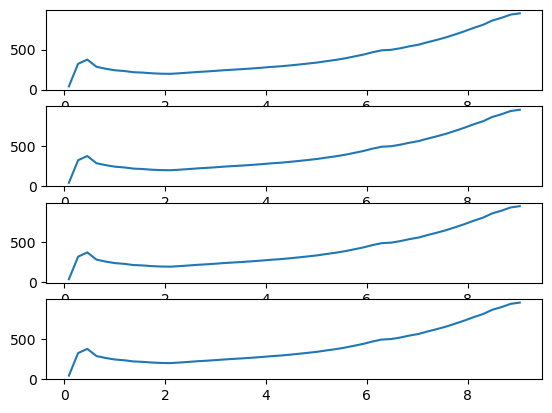

In [34]:
fig, ax = plt.subplots(4)
for i in range(4):
    ax[i].plot(PS[0]['k'], PS[0]['delta']*PS[0]['k']**3)
    #ax[i].set_xscale("log")
    #ax[i].set_yscale("log")

In [12]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=False,
   ignore_kperp_zero=True,
   ignore_kpar_zero=True,
   ignore_k_zero=True,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, dtype=int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def powerspectra(brightness_temp, n_psbins=50, nchunks=4, min_k=0.1, max_k=1.0, logk=False):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))

    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (100, 100, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power})
    return data



# do 5 chunks but only plot 1 - 4, the 0th has no power for minihalo models where xH=0
nchunks = 4

PS = powerspectra(test.data[0])

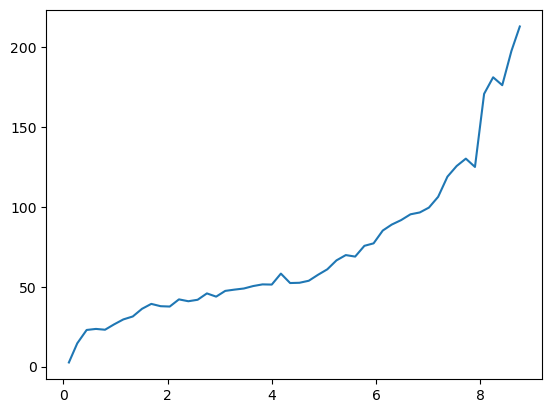

In [31]:
ps, k = get_power(test.data[0].brightness_temp[:,:,50], boxlength=(100,100), bins=50)
plt.plot(k,ps*k**3)

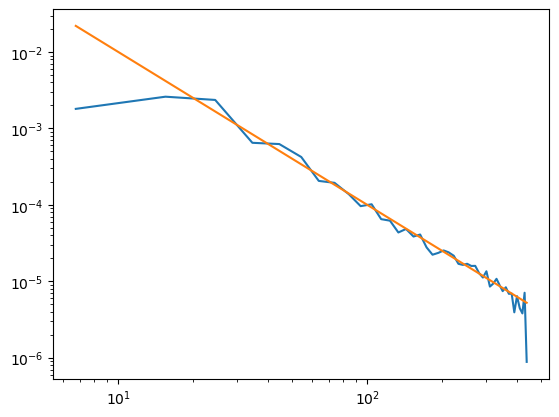

In [11]:
from powerbox import PowerBox
import matplotlib.pyplot as plt
pb = PowerBox(100,lambda k : k**-2.)
p,k = get_power(pb.delta_x(),pb.boxlength)
plt.plot(k,p)
plt.plot(k,k**-2.)
plt.xscale('log')
plt.yscale('log')

In [35]:
k

array([0.10635158, 0.26708689, 0.44695136, 0.62520983, 0.79987183,
       0.97254258, 1.1512525 , 1.33238897, 1.50944901, 1.68722766,
       1.86672714, 2.04146028, 2.21797597, 2.39818945, 2.57617064,
       2.75441372, 2.93202224, 3.10615689, 3.28417607, 3.46362915,
       3.64130736, 3.82054305, 3.99882654, 4.17394062, 4.35071134,
       4.52985277, 4.70888214, 4.88705756, 5.06425415, 5.24043265,
       5.41909081, 5.59879043, 5.77605381, 5.95226056, 6.12855976,
       6.30090147, 6.48015455, 6.66019756, 6.83908405, 7.01416307,
       7.19133776, 7.36955164, 7.54676514, 7.7226107 , 7.89772407,
       8.07311276, 8.24634374, 8.42111333, 8.59711117, 8.75791822])

In [ ]:
np.rand

Object `np.randint` not found.


In [ ]:
np.fromstring(os.urandom(4))

/tmp/ipykernel_3981/1617486966.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np.fromstring(os.urandom(4))


ValueError: string size must be a multiple of element size

In [ ]:
test

{'_cobj': <cdata 'struct GlobalParams &' 0x7285e3468e60>,
 '_ffi': <_cffi_backend.FFI at 0x72869433c660>,
 'EVOLVE_DENSITY_LINEARLY': 0,
 'SMOOTH_EVOLVED_DENSITY_FIELD': 0,
 'R_smooth_density': 0.20000000298023224,
 'HII_ROUND_ERR': 9.999999747378752e-06,
 'FIND_BUBBLE_ALGORITHM': 2,
 'N_POISSON': 5,
 'T_USE_VELOCITIES': 1,
 'MAX_DVDR': 0.20000000298023224,
 'DELTA_R_HII_FACTOR': 1.100000023841858,
 'DELTA_R_FACTOR': 1.100000023841858,
 'HII_FILTER': 1,
 'INITIAL_REDSHIFT': 300.0,
 'R_OVERLAP_FACTOR': 1.0,
 'DELTA_CRIT_MODE': 1,
 'HALO_FILTER': 0,
 'OPTIMIZE': 0,
 'OPTIMIZE_MIN_MASS': 99999997952.0,
 'CRIT_DENS_TRANSITION': 1.5,
 'MIN_DENSITY_LOW_LIMIT': 9.000000034120603e-08,
 'RecombPhotonCons': 0,
 'PhotonConsStart': 0.9950000047683716,
 'PhotonConsEnd': 0.30000001192092896,
 'PhotonConsAsymptoteTo': 0.009999999776482582,
 'PhotonConsEndCalibz': 3.5,
 'HEAT_FILTER': 0,
 'CLUMPING_FACTOR': 2.0,
 'Z_HEAT_MAX': 35.0,
 'R_XLy_MAX': 500.0,
 'NUM_FILTER_STEPS_FOR_Ts': 40,
 'ZPRIME_STEP_FA

In [ ]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getattr__(self, name: str):
        return self.__dict__[f"_{name}"]

    def __setattr__(self, name, value):
        self.__dict__[f"_{name}"] = value

In [79]:
x = {"two": [3,2],"three": [3,2] ,"four": [4,1]}

In [84]:
y = {}
for values in itertools.product(*x.values()):
    print((lambda d, values: {k: v for k, v in zip(d.keys(), values)})(x, values))
    

{'two': 3, 'three': 3, 'four': 4}
{'two': 3, 'three': 3, 'four': 1}
{'two': 3, 'three': 2, 'four': 4}
{'two': 3, 'three': 2, 'four': 1}
{'two': 2, 'three': 3, 'four': 4}
{'two': 2, 'three': 3, 'four': 1}
{'two': 2, 'three': 2, 'four': 4}
{'two': 2, 'three': 2, 'four': 1}


In [81]:
dict.update?

Docstring:
D.update([E, ]**F) -> None.  Update D from dict/iterable E and F.
If E is present and has a .keys() method, then does:  for k in E: D[k] = E[k]
If E is present and lacks a .keys() method, then does:  for k, v in E: D[k] = v
In either case, this is followed by: for k in F:  D[k] = F[k]
Type:      method_descriptor

In [74]:
y.update({"1": 2})

In [75]:
y

{'1': 2, '2': 2}